![example 6.5](assets/6.4_example_6.5.png)

Example 6.5: Windy Gridworld Shown inset below is a standard gridworld, with
start and goal states, but with one di↵erence: there is a crosswind running upward
through the middle of the grid. The actions are the standard four—up, down, right,
and left—but in the middle region the resultant next states are shifted upward by a
“wind,” the strength of which varies from column to column. The strength of the wind
is given below each column (0, 0, 0, 1, 1, 1, 2, 1, 0), in number of cells shifted upward. For example, if you are one cell to the
right of the goal, then the action
left takes you to the cell just above
the goal. This is an undiscounted
episodic task, with constant rewards
of 1 until the goal state is reached.
The graph to the right shows the
results of applying "-greedy Sarsa to
this task, with " = 0.1, ↵ = 0.5,
and the initial values Q(s, a)=0
for all s, a. The increasing slope of
the graph shows that the goal was
reached more quickly over time. By
8000 time steps, the greedy policy was long since optimal (a trajectory from it is shown
inset); continued "-greedy exploration kept the average episode length at about 17 steps,
two more than the minimum of 15. Note that Monte Carlo methods cannot easily be
used here because termination is not guaranteed for all policies. If a policy was ever
found that caused the agent to stay in the same state, then the next episode would
never end. Online learning methods such as Sarsa do not have this problem because they
quickly learn during the episode that such policies are poor, and switch to something
else.

In [419]:
import numpy as np
import matplotlib.pyplot as plt

ROWS = 7
COLS = 10
T_STATE = (3, 7)
WIND_STRENGTH = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 2,
    7: 2,
    8: 1,
    9: 0
}

def get_next_state(state, action):
    row, col = state
    if action == "left":
        new_pos = (row, col - 1)
    elif action == "right":
        new_pos = (row, col + 1)
    elif action == "up":
        new_pos = (row - 1, col)
    elif action == "down":
        new_pos = (row + 1, col)
    
    new_pos = (max(0, new_pos[0] - WIND_STRENGTH[new_pos[1]]), new_pos[1])
    return new_pos

def get_next_action(state, action_values, epsilon=0.1):
    available_actions = []
    if state[0] > 0:
        available_actions.append("up")
    if state[0] < ROWS - 1:
        available_actions.append("down")
    if state[1] > 0:
        available_actions.append("left")
    if state[1] < COLS - 1:
        available_actions.append("right")

    if np.random.random() < epsilon:
        return np.random.choice(available_actions)
    else:
        return max(available_actions, key=lambda action: action_values[state[0]][state[1]][action])
    
def get_reward(state, action):
    if state == T_STATE:
        return 0
    else:
        return -1

INITIAL_STATE_ACTION_VALUES = [[{
    "left": 0,
    "right": 0,
    "up": 0,
    "down": 0
} for _ in range(10)] for _ in range(7)]

In [420]:
import copy

def train_sarsa(
    initial_state_action_values,
    alpha=0.5,
    epsilon=0.1,
    episodes=200,
    decay_steps=None
):
    state_action_values = copy.deepcopy(initial_state_action_values)
    step_episodes = []
    for i in range(episodes):
        state = state = (3, 0)
        action = get_next_action(state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
        while state != T_STATE:
            step_episodes.append(i)
            reward = get_reward(state, action)
            next_state = get_next_state(state, action)
            next_action = get_next_action(next_state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
            state_action_values[state[0]][state[1]][action] += alpha * (reward + state_action_values[next_state[0]][next_state[1]][next_action] - state_action_values[state[0]][state[1]][action])
            state = next_state
            action = next_action

    return state_action_values, step_episodes

def get_epsilon(episode, initial_eps=.1, final_eps=0.001, decay_steps=150):
    if episode >= decay_steps:
        return final_eps
    return initial_eps - (initial_eps - final_eps) * (episode / decay_steps)

def generate_episode(state_action_values, epsilon=0.1):
    state = (3, 0)
    episode = [state]
    while state != T_STATE:
        action = get_next_action(state, state_action_values, epsilon)
        state = get_next_state(state, action)
        episode.append(state)
    
    return episode

def plot_episode(state_action_values, epsilon=0.1):
    episode_path = generate_episode(state_action_values, epsilon)
    print(len(episode_path))

    cols = [pos[1] for pos in episode_path]
    rows = [pos[0] for pos in episode_path]

    # Simple plot with dots
    plt.figure(figsize=(12, 8))
    plt.plot(cols, rows, 'o-', markersize=8, linewidth=2, label='Episode path')
    
    # Mark start and goal states
    plt.plot(0, 3, 's', markersize=12, color='green', label='Start (3,0)')
    plt.plot(7, 3, '*', markersize=15, color='red', label='Goal (3,7)')
    
    plt.xlim(-0.5, COLS - 0.5)  # 0 to 9 for columns
    plt.ylim(-0.5, ROWS - 0.5)  # 0 to 6 for rows
    
    # Add grid and formatting
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()  # Flip y-axis so row 0 is at top
    
    # Add axis labels and title
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    # Set integer ticks for better grid visualization
    plt.xticks(range(COLS))
    plt.yticks(range(ROWS))
    
    plt.tight_layout()
    plt.show()

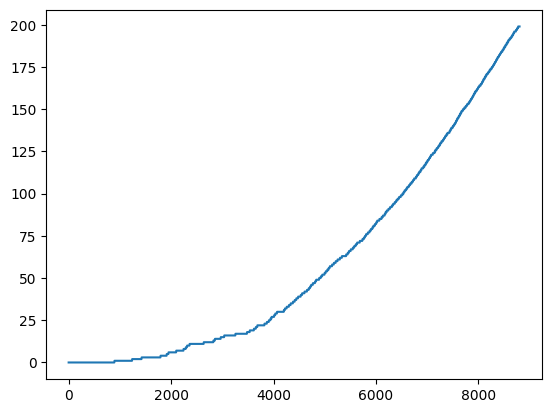

In [421]:
state_action_values, step_episodes = train_sarsa(
    INITIAL_STATE_ACTION_VALUES,
    alpha=0.5,
    epsilon=0.1,
    episodes=200
)

plt.plot(step_episodes)
plt.show()

21


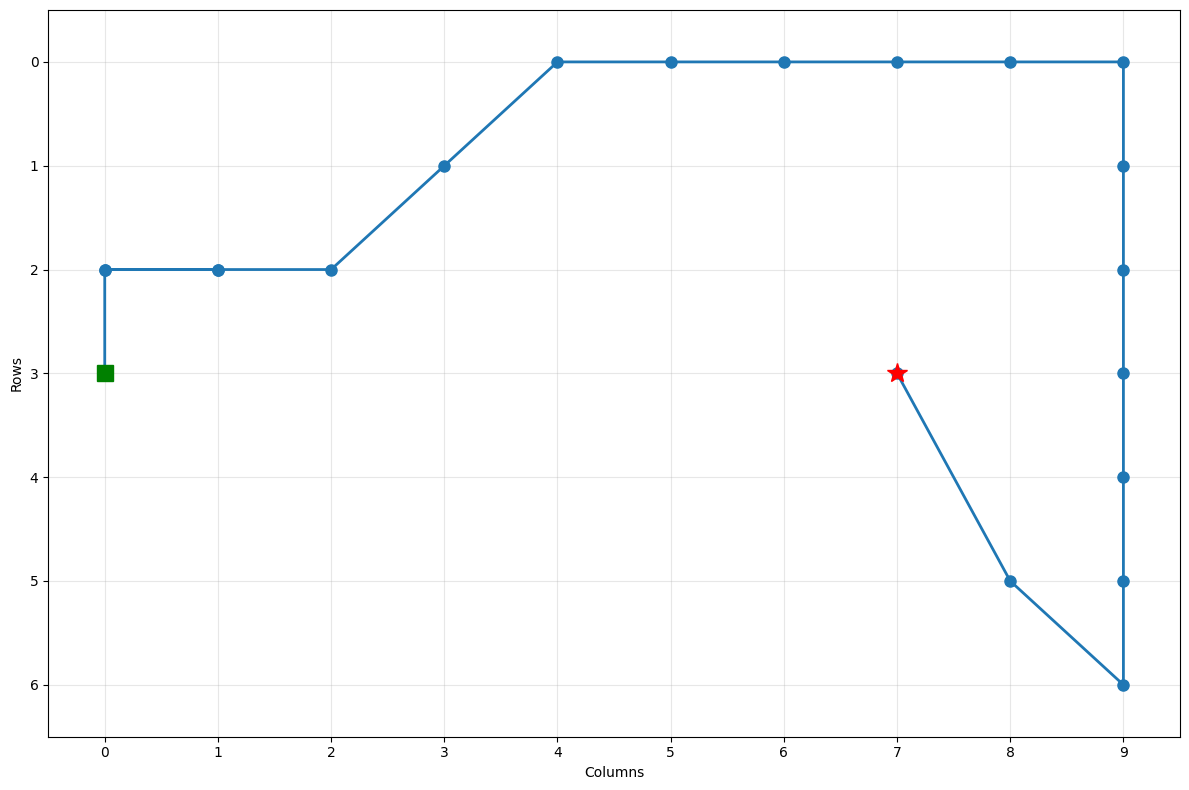

19


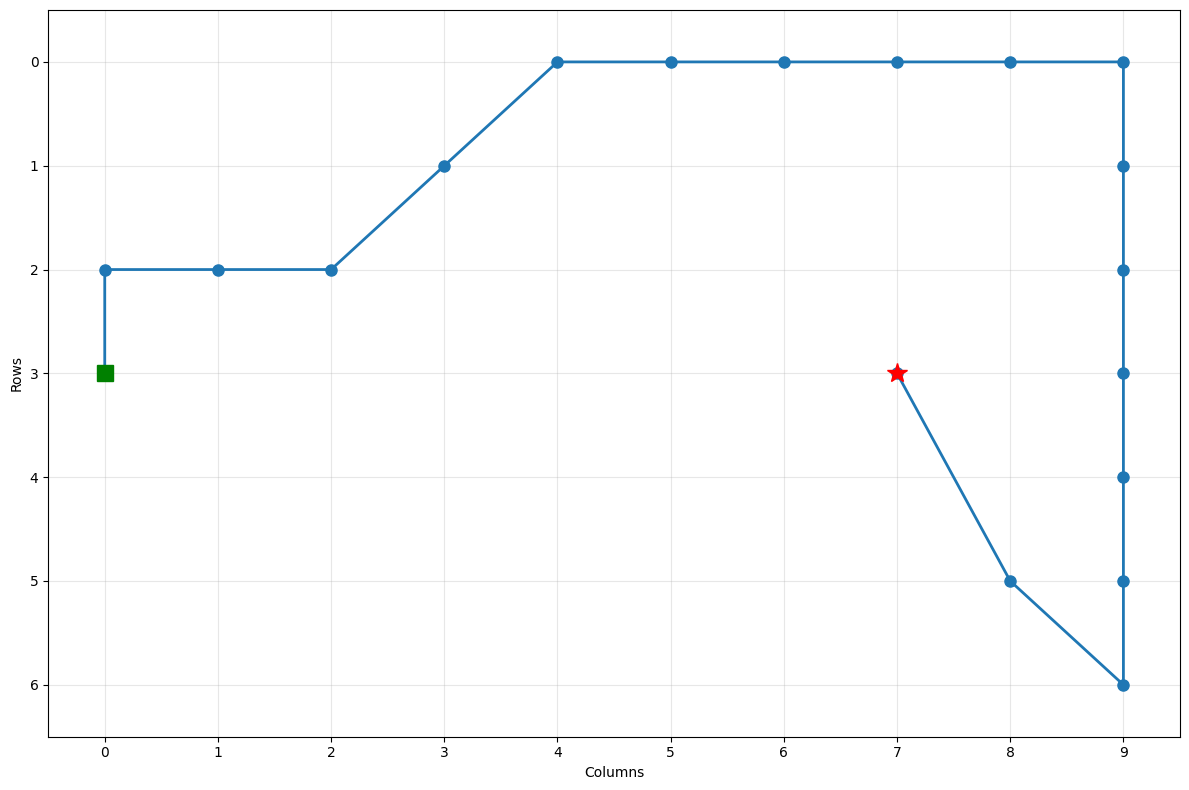

In [422]:
plot_episode(state_action_values, epsilon=0.1)
plot_episode(state_action_values, epsilon=0.00001)

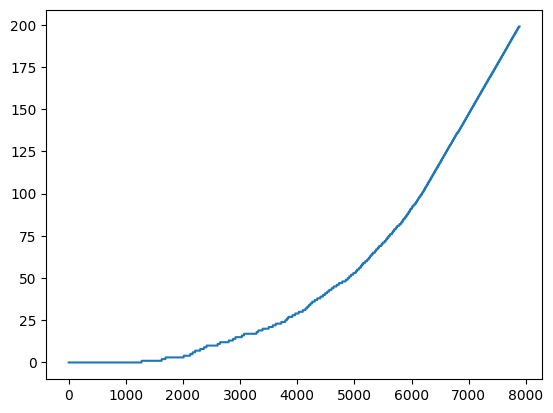

In [423]:
state_action_values, step_episodes = train_sarsa(
    INITIAL_STATE_ACTION_VALUES,
    alpha=0.5,
    epsilon=0.1,
    episodes=200,
    decay_steps=150
)

plt.plot(step_episodes)
plt.show()

57


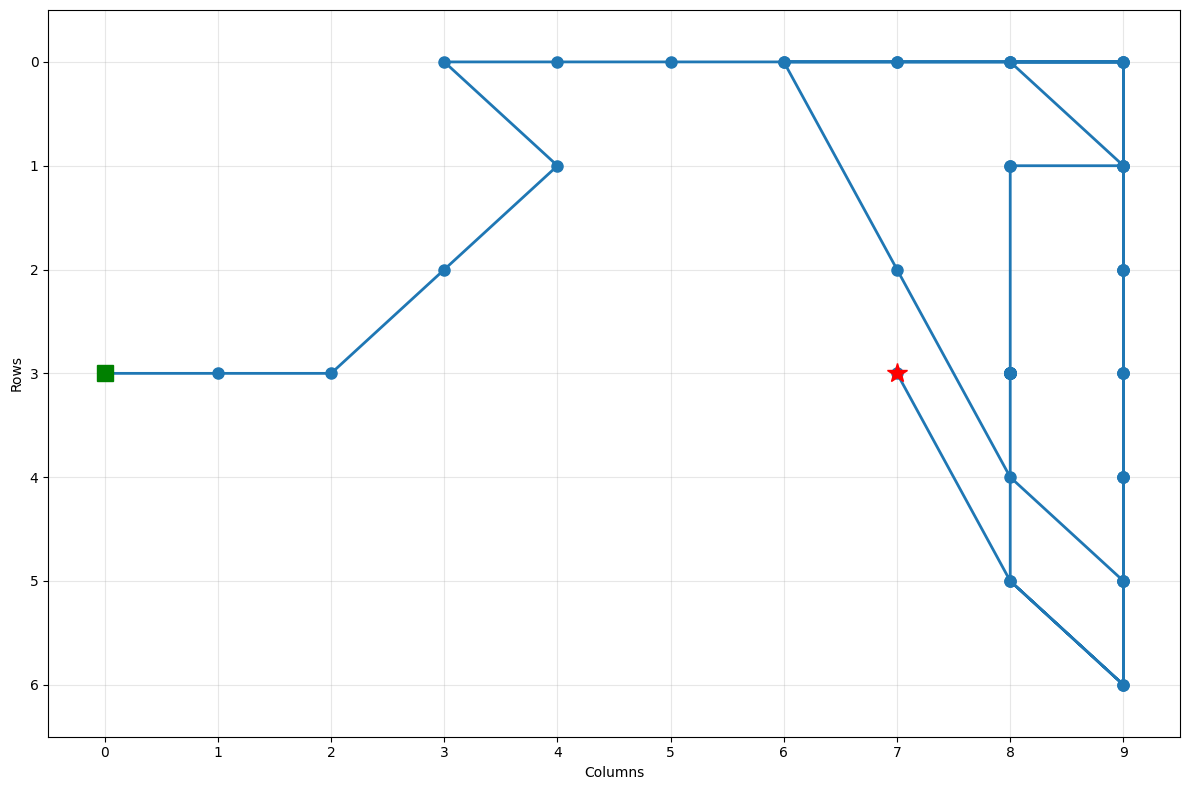

18


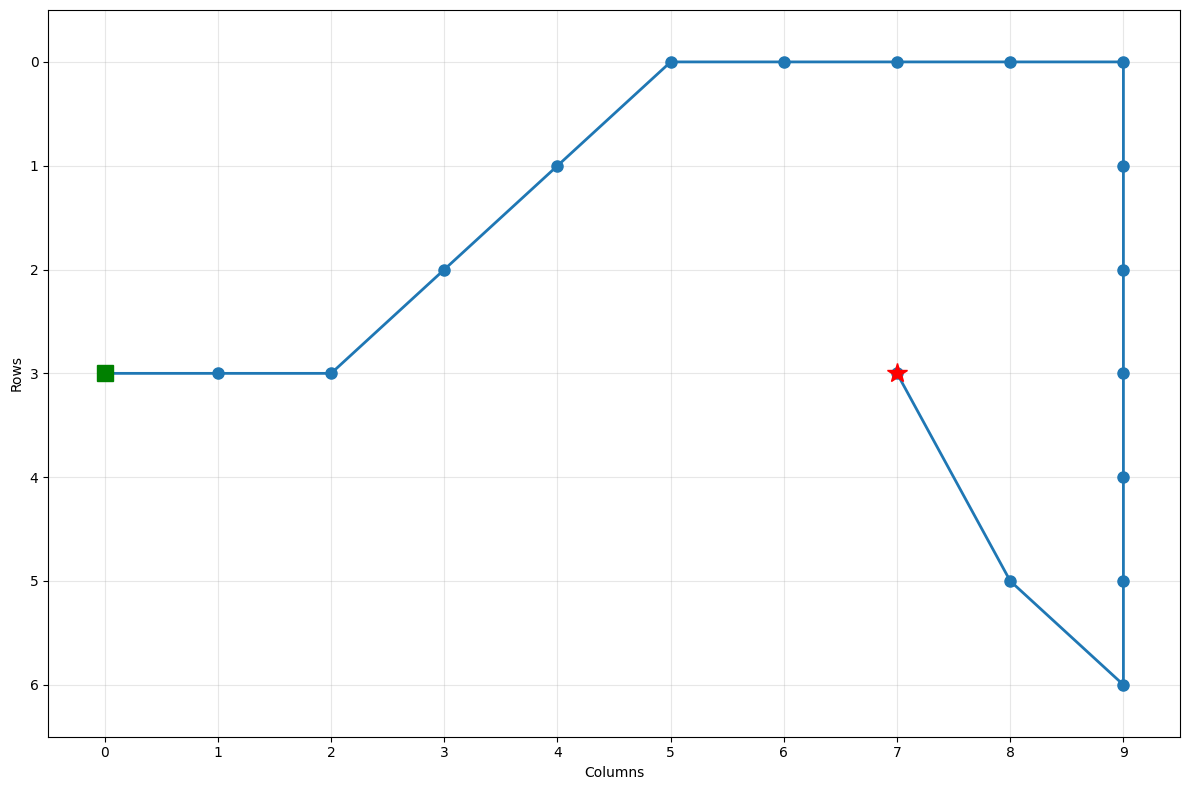

In [424]:
plot_episode(state_action_values, epsilon=0.1)
plot_episode(state_action_values, epsilon=0.00001)